In [2]:
import numpy as np 
import pandas as pd
import pickle, glob
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")


In [5]:
def readtide(path, begintime=t1, endtime=t2):
    def get_strtime(time):
        time = to_datetime(time)
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}'
    

    dtide_ori = pd.read_csv(path, skiprows=20)
    begin = get_strtime(begintime); end = get_strtime(endtime)
    dtide_ori = dtide_ori[dtide_ori['yyyymmddhh'] >= int(begin)][dtide_ori['yyyymmddhh'] <= int(end)]
    tide = {'time':[], 'height':[], 'diff':[]}
    
    for time in dtide_ori['yyyymmddhh']:
        timestr = str(time)
        yyyy = int(timestr[:4])
        mm  = int(timestr[4:6])
        dd = int(timestr[6:8])
        hh = int(timestr[8:10])
        dtide_temp = dtide_ori[dtide_ori['yyyymmddhh']==time]
        for minn_str in [':00', ':06', ':12', ':18', ':24', ':30', ':36', ':42', ':48', ':54']:
            tideheight = dtide_temp[minn_str].values[0]
            minn = int(minn_str.rsplit(':')[-1])
            tide['time'].append(datetime(yyyy,mm,dd,hh,minn))
            tide['height'].append(tideheight)

    for j in range(len(tide['height'])):
        if j+1 != len(tide['height']):
            h1 = tide['height'][j]
            h2 = tide['height'][j+1]

            diff = (h2 - h1)/(6*60)
            tide['diff'].append(diff)
        else:
            tide['diff'].append(np.nan)
    df = pd.DataFrame(tide)
    return df 

def to_datetime(date):

    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

def nan_argsort(matrix):
    temp = matrix.copy()
    temp[np.isnan(matrix)] = np.inf
    return temp.argsort()
def sort_df(df_time):
    df_time = df_time.reset_index(drop=True)
    index_vel = np.where(abs(df_time['diff'])<=0.05)[0] #0.075
    df_time = df_time[df_time.index.isin(index_vel)]
    df_clear = df_time.reset_index(drop=True)

    sorted_height = df_clear['height'][nan_argsort(df_clear['height'])]
    sorted_height_nonan = sorted_height[~np.isnan(sorted_height)]
    return df_clear, sorted_height_nonan

In [4]:
year = 2023
place = 'Taoyuan'
path = glob.glob(f'../Results/soundsepration/{place}-5min/202?*_{year}_4stage_separation/')[0]
df = pd.read_pickle(glob.glob(f"{path}/{place}_{year}_diurnal_variations_nostd_{year}??_S1.pkl")[0])  

days, hr = df['level'].shape

dtime = pd.read_csv(f"{path}/{place}_{year}_index_variations.csv")
dtime = pd.to_datetime(dtime['Time'][~dtime['H'].isna()])
t1 = dtime.values[0]; t2 = dtime.values[-1]

In [137]:
path

'../Results/soundsepration/Keelung-5min/20240129_100849_2022_3stage_separation/'

In [138]:
dtide = readtide(f'../DataBase/Data_CWA/{year}_1116_竹圍_tide.csv', begintime=t1, endtime=t2)
maxtime = []
mintime = []
for dd in range(1, days):
    t = to_datetime(t1) + timedelta(days=dd)
    year = t.year
    month = t.month
    day = t.day
    
    for hr in [0, 12]:
        dtide_ = dtide[dtide['time']>=datetime(year, month, day, hr, 0)][dtide['time']<=datetime(year, month, day, hr+11, 59)]  
        df_clear, sorted_height_nonan = sort_df(dtide_)
        try:
            min_h_time = [df_clear['time'][i] for i in sorted_height_nonan[:1].index][0]
            max_h_time = [df_clear['time'][i] for i in sorted_height_nonan[-1:].index][0]
        
            maxtime.append(max_h_time)
            mintime.append(min_h_time)
        
        except:
            pass

plot_tide_max= np.full((days, 288), np.nan) #48
plot_tide_min= np.full((days, 288), np.nan)

for i in range(len(maxtime)):
    maxx = maxtime[i]    
    
    # max tidal height 
    index_diff_day = (maxx-t1).days
    total_minn_in_day = maxx.hour*60+maxx.minute
    ind_in_day = int(total_minn_in_day/5)
    
    plot_tide_max[index_diff_day,ind_in_day] = 1
    plot_tide_max[index_diff_day,ind_in_day+1] = 1
for i in range(len(mintime)):
    minn = mintime[i]
    # max tidal height 
    index_diff_day = (minn-t1).days
    total_minn_in_day = minn.hour*60+minn.minute
    ind_in_day = int(total_minn_in_day/5)
    
    plot_tide_min[index_diff_day,ind_in_day] = 1
    plot_tide_min[index_diff_day,ind_in_day+1] = 1

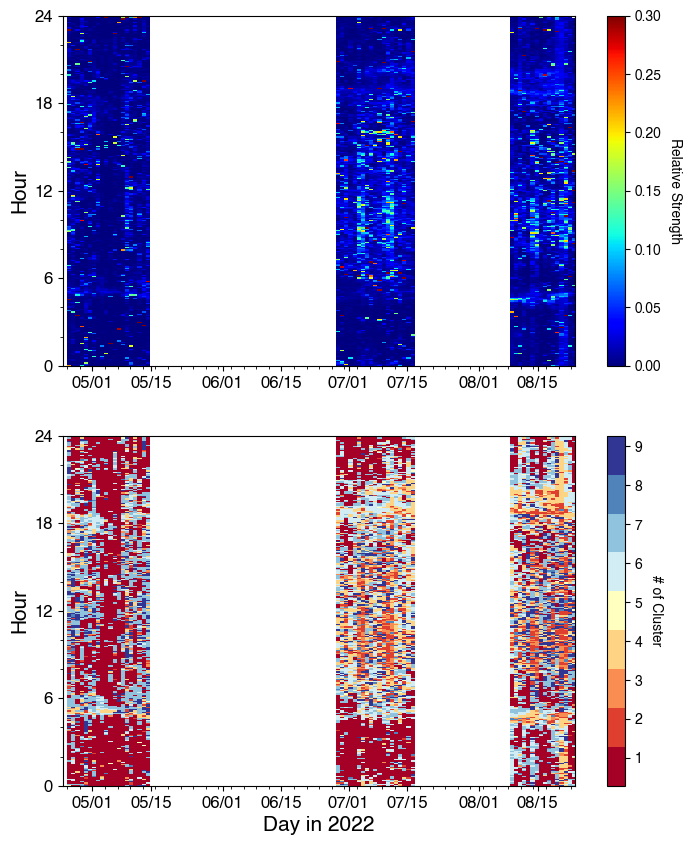

In [139]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(2, 1, figsize=(days/15, 10))
hr_boundary = [0, 24]
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates

    
im1 = ax[0].imshow(df['level'].T, vmin=(np.nanmin(df['level'])), vmax=0.3, #(np.nanmax(df['level'])), 
            origin='lower', aspect='auto', cmap=cm.jet, interpolation='none',
            extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
            
# im2 = ax.imshow(plot_tide_max.T, vmin=0, vmax=1, 
#             origin='lower', aspect='auto', cmap=cm.Reds, interpolation='none',
#             extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
# im3 = ax.imshow(plot_tide_min.T, vmin=0, vmax=1, 
#             origin='lower', aspect='auto', cmap=cm.Reds_r, interpolation='none',
#             extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])

ax[0].xaxis_date()
ax[0].set_ylabel('Hour', fontsize=15)
ax[0].yaxis.set_minor_locator(MultipleLocator(2))
ax[0].yaxis.set_major_locator(MultipleLocator(6))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[0].tick_params(axis='both', which='major', labelsize=12)
cbar1 = plt.colorbar(im1)  
cbar1.ax.get_yaxis().labelpad = 15
cbar1.set_label('Relative Strength', rotation=270)


n_clusters=int(np.nanmax(df['cluster']))

#-------- specific colorbar 
# cptpath = '/Users/tong/opt/get-cpt'
# import os, sys
# sys.path.append(cptpath)
# import get_cpt
# cmap_url = 'http://soliton.vm.bytemark.co.uk/pub/cpt-city/gmt/GMT_panoply.cpt'
# cmap = get_cpt.get_cmap(cmap_url, method='list', N=n_clusters)
cmap = cm.get_cmap('RdYlBu', n_clusters)
im2 = ax[1].imshow(df['cluster'].T, vmin=int(np.nanmin(df['cluster'])), vmax=int(np.nanmax(df['cluster'])), 
                origin='lower', aspect='auto', cmap=cmap, interpolation='none',
                extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])
# ax[1].xaxis_date()
ax[1].set_ylabel('Hour', fontsize=15)
ax[1].set_xlabel(f'Day in {year}', fontsize=15)
ax[1].yaxis.set_minor_locator(MultipleLocator(2))
ax[1].yaxis.set_major_locator(MultipleLocator(6))
ax[1].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar2 = plt.colorbar(im2)  
cbar2.ax.get_yaxis().labelpad = 15
cbar2.set_label('# of Cluster', rotation=270)
if n_clusters == 2:
    tick_locs = (np.arange(1, n_clusters+1) )*(n_clusters-1)/n_clusters
else:
    tick_locs = (np.arange(1, n_clusters+1) + 0.85)*(n_clusters-1)/n_clusters
cbar2.set_ticks(tick_locs)
cbar2.set_ticklabels(np.arange(1, n_clusters+1))


fig.savefig(f'{path}/{place}_{year}_noise_diurnal_variations_wTidal.png', dpi=200)
fig.savefig(f'{path}/{place}_{year}_noise_diurnal_variations_wTidal.pdf', dpi=200)

In [6]:
sunpath = f'../DataBase/Data_CWA/sunset_time_taoyuan{year}.csv'
dsun = pd.read_csv(sunpath)
delta_day = to_datetime(t2)- to_datetime(t1)
sun_df = {'time':[], 'sunrise': [], 'sunset':[]}

for idx in range(0, delta_day.days+1,2):
    current_day = to_datetime(t1)+timedelta(days=idx)
    year = current_day.year
    month = current_day.month
    day = current_day.day

    sunset_hr = int((dsun['SUNSET'][dsun['TIME']==f'{year}/{month}/{day}'].values[0]).rsplit(':')[0])
    sunset_min = int((dsun['SUNSET'][dsun['TIME']==f'{year}/{month}/{day}'].values[0]).rsplit(':')[-1])
    sunrise_hr = int((dsun['SUNRSET'][dsun['TIME']==f'{year}/{month}/{day}'].values[0]).rsplit(':')[0])
    sunrise_min = int((dsun['SUNRSET'][dsun['TIME']==f'{year}/{month}/{day}'].values[0]).rsplit(':')[-1])  
    
    sun_df['time'].append(datetime(year, month, day))
    sun_df['sunrise'].append(sunrise_hr+(sunrise_min/60))
    sun_df['sunset'].append(sunset_hr+(sunset_min/60))

In [7]:
dtide = readtide(f'../DataBase/Data_CWA/{year}_1116_竹圍_tide.csv', begintime=t1, endtime=t2)
# dtide = readtide(f'../DataBase/Data_CWA/{year}_12191_長潭里_tide.csv', begintime=t1, endtime=t2)
tide_df = {'time':[], 'max': [], 'min':[]}
for dd in range(1, days):
    t = to_datetime(t1) + timedelta(days=dd)
    year = t.year
    month = t.month
    day = t.day
    
    for hr in [0, 12]:
        dtide_ = dtide[dtide['time']>=datetime(year, month, day, hr, 0)][dtide['time']<=datetime(year, month, day, hr+11, 59)]  
        df_clear, sorted_height_nonan = sort_df(dtide_)
        try:
            min_h_time = [df_clear['time'][i] for i in sorted_height_nonan[:1].index][0]
            max_h_time = [df_clear['time'][i] for i in sorted_height_nonan[-1:].index][0]
            tide_df['time'].append(datetime(year, month, day))
            tide_df['max'].append(max_h_time.hour+max_h_time.minute/60)
            tide_df['min'].append(min_h_time.hour+min_h_time.minute/60)
        
        except:
            pass

In [ ]:
year = 2023
place = 'Taoyuan'

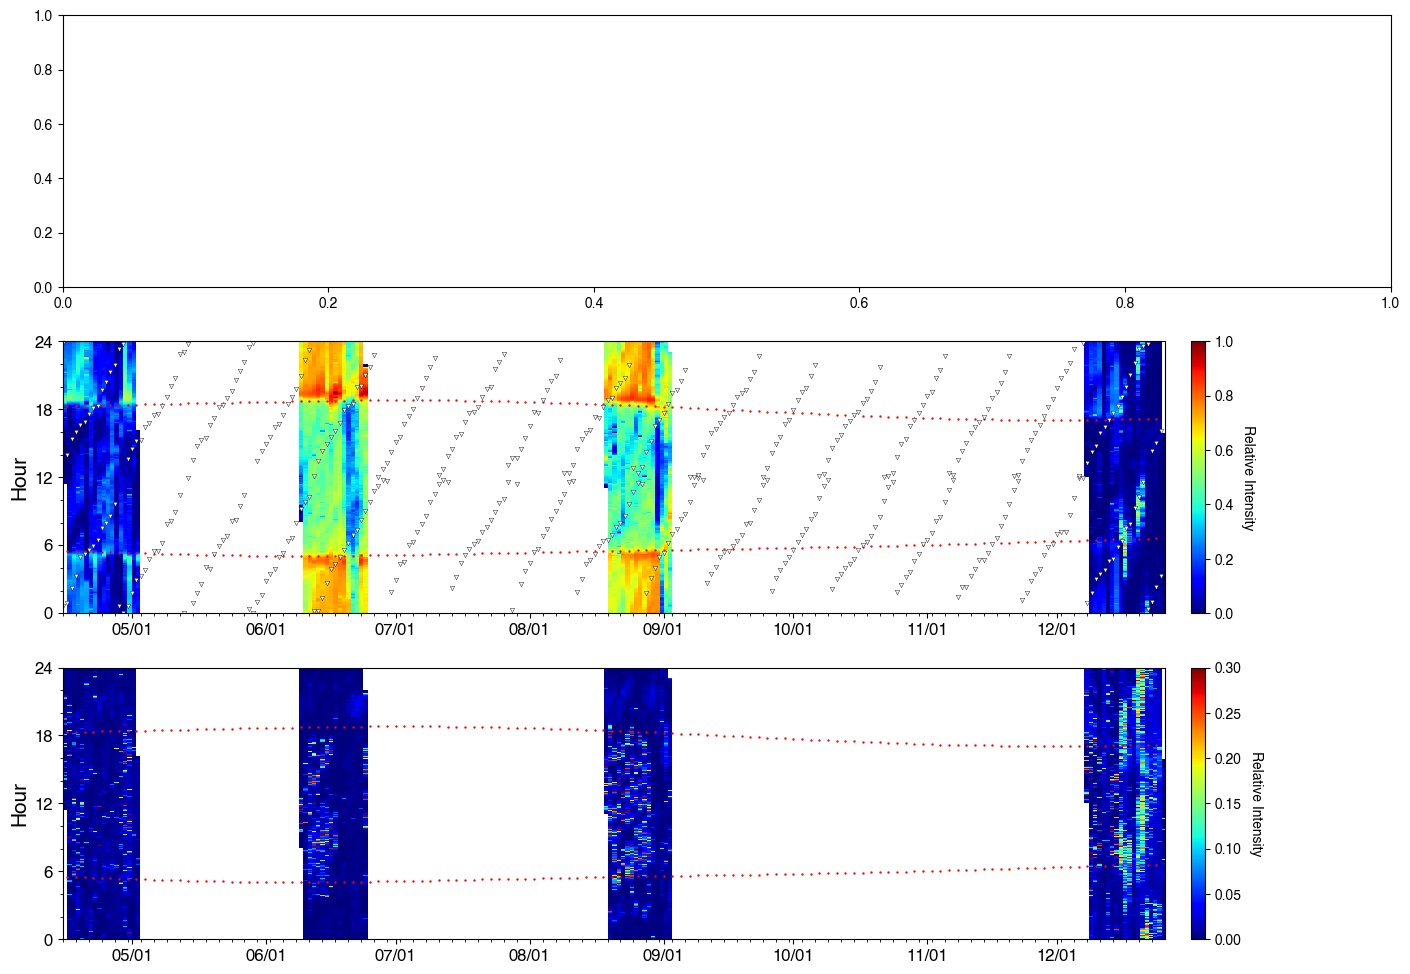

In [19]:
plt.rcParams["font.family"] = "Helvetica"
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
fig, ax = plt.subplots(3, 1, figsize=(days/15, 12))
hr_boundary = [0, 24]
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates

axis = plt.gca()


path = glob.glob(f'../Results/soundsepration/{place}-5min/202?*_{year}_4stage_separation/')[0]
df = pd.read_pickle(glob.glob(f"{path}/{place}_{year}_diurnal_variations_nostd_{year}??_S1.pkl")[0])  
days, hr = df['level'].shape

dtime = pd.read_csv(f"{path}/{place}_{year}_index_variations.csv")
dtime = pd.to_datetime(dtime['Time'][~dtime['H'].isna()])
t1 = dtime.values[0]; t2 = dtime.values[-1]
im1 = ax[1].imshow(df['level'].T, vmin=(np.nanmin(df['level'])), vmax=(np.nanmax(df['level'])), 
            origin='lower', aspect='auto', cmap=cm.jet, interpolation='none',
            extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])

ax[1].scatter(sun_df['time'], sun_df['sunrise'],color='red',marker="o", s=0.5)  # <- MOVE HERE
ax[1].scatter(sun_df['time'], sun_df['sunset'],color='red',marker="o", s=0.5)

ax[1].scatter(tide_df['time'], tide_df['min'],color='white',marker="v", s=10, edgecolors='k', lw=0.3)  # <- MOVE HERE
# ax[0].scatter(tide_df['time'], tide_df['max'],color='white',marker="^", s=5)

ax[1].set_xlim(to_datetime(t1), to_datetime(t2))
divider = make_axes_locatable(axis)

ax[1].xaxis_date()
ax[1].set_ylabel('Hour', fontsize=15)
ax[1].yaxis.set_minor_locator(MultipleLocator(2))
ax[1].yaxis.set_major_locator(MultipleLocator(6))
ax[1].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar1 = plt.colorbar(im1,pad=0.02)  
cbar1.ax.get_yaxis().labelpad = 15
cbar1.set_label('Relative Intensity', rotation=270)

#===============
path = glob.glob(f'../Results/soundsepration/{place}-5min/202?*_{year}_4stage_separation/')[0]
df = pd.read_pickle(glob.glob(f"{path}/{place}_{year}_diurnal_variations_nostd_{year}??_S0.pkl")[0])  
days, hr = df['level'].shape

dtime = pd.read_csv(f"{path}/{place}_{year}_index_variations.csv")
dtime = pd.to_datetime(dtime['Time'][~dtime['H'].isna()])
t1 = dtime.values[0]; t2 = dtime.values[-1]
im1 = ax[2].imshow(df['level'].T, vmin=(np.nanmin(df['level'])), vmax=0.3, #(np.nanmax(df['level'])), 
            origin='lower', aspect='auto', cmap=cm.jet, interpolation='none',
            extent=[t1, t2, np.min(hr_boundary), np.max(hr_boundary)])

ax[2].scatter(sun_df['time'], sun_df['sunrise'],color='red',marker="o", s=0.5)  # <- MOVE HERE
ax[2].scatter(sun_df['time'], sun_df['sunset'],color='red',marker="o", s=0.5)

# ax[2].scatter(tide_df['time'], tide_df['min'],color='white',marker="v", s=10, edgecolors='k', lw=0.3)  # <- MOVE HERE
# ax[0].scatter(tide_df['time'], tide_df['max'],color='white',marker="^", s=5)

ax[2].set_xlim(to_datetime(t1), to_datetime(t2))
divider = make_axes_locatable(axis)

ax[2].xaxis_date()
ax[2].set_ylabel('Hour', fontsize=15)
ax[2].yaxis.set_minor_locator(MultipleLocator(2))
ax[2].yaxis.set_major_locator(MultipleLocator(6))
ax[2].xaxis.set_minor_locator(mdates.DayLocator(interval=3))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax[2].tick_params(axis='both', which='major', labelsize=12)
cbar1 = plt.colorbar(im1, pad=0.02)  
cbar1.ax.get_yaxis().labelpad = 15
cbar1.set_label('Relative Intensity', rotation=270)

# plt.savefig(f'{path}/{place}_{year}_diurnal_variations_wTidalandSun.png', dpi=200)
# plt.savefig(f'{path}/{place}_{year}_diurnal_variations_wTidalandSun.pdf', dpi=200)

datetime.datetime(2023, 4, 14, 23, 0)